# HW : 이미지 분류 실습 (MLP)

### 이 실습에서는 MLP 기반 이미지 분류기를 직접 설계하고 학습시켜봅니다.
- 다양한 기법을 실험하면서 성능을 비교합니다.
- 자유롭게 모델을 개선하고 최적의 성능을 찾아보세요!
- 아래의 코드는 데이터를 불러오는 예시 코드입니다(수정가능).
- Tensorflow 혹은 Pytouch, 더 나아가 Numpy 코딩도 가능합니다.

> ⚠️ 주의 필독

- `모든 문제에서 validation dataset은 train dataset의 10%로 고정!`
- `Test set 변경 불가능 및 학습 과정에서 모델에 노출되면 0점 처리`
- 최종 제출하는 model parameter로 재구현했을 때, 해당 성능과 근접하게 안나오면 `과제 전체 0점 처리`

## '''

In [39]:
'''## 참고하세요. CIFAR-10은 다양한 방법으로 구할 수 있습니다. 예를 들어 다음과 같습니다.

from tensorflow.keras.datasets import cifar10

# 데이터 로드
(x_train_c, y_train_c), (x_test_c, y_test_c) = cifar10.load_data()'''

'## 참고하세요. CIFAR-10은 다양한 방법으로 구할 수 있습니다. 예를 들어 다음과 같습니다.\n\nfrom tensorflow.keras.datasets import cifar10\n\n# 데이터 로드\n(x_train_c, y_train_c), (x_test_c, y_test_c) = cifar10.load_data()'

In [40]:
'''## 참고하세요. fashion_mnist은 다양한 방법으로 구할 수 있습니다.

from tensorflow.keras.datasets import fashion_mnist

(x_train_f, y_train_f), (x_test_f, y_test_f) = fashion_mnist.load_data()'''

'## 참고하세요. fashion_mnist은 다양한 방법으로 구할 수 있습니다.\n\nfrom tensorflow.keras.datasets import fashion_mnist\n\n(x_train_f, y_train_f), (x_test_f, y_test_f) = fashion_mnist.load_data()'

In [41]:
'''# 혹은 아래처럼 해도 됩니다.

import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

def get_data_loaders(data_name, batch_size=64, valid_ratio=0.1):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Fashion-MNIST 데이터셋 다운로드 (train, test)
    if data_name == "FashionMNIST":
      full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
      test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    elif data_name =="CIFAR10":
      full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
      test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Train/Validation split
    n_total = len(full_train_dataset)
    n_valid = int(n_total * valid_ratio)
    n_train = n_total - n_valid
    train_dataset, valid_dataset = random_split(full_train_dataset, [n_train, n_valid])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train samples: {n_train}, Validation samples: {n_valid}, Test samples: {len(test_dataset)}")
    return train_loader, valid_loader, test_loader

# DataLoader 실행 예시
train_loader, valid_loader, test_loader = get_data_loaders(data_name="CIFAR10",batch_size=64)'''

'# 혹은 아래처럼 해도 됩니다.\n\nimport torch\nfrom torch.utils.data import DataLoader, random_split\nimport torchvision\nimport torchvision.transforms as transforms\n\ndef get_data_loaders(data_name, batch_size=64, valid_ratio=0.1):\n    transform = transforms.Compose([\n        transforms.ToTensor(),\n    ])\n\n    # Fashion-MNIST 데이터셋 다운로드 (train, test)\n    if data_name == "FashionMNIST":\n      full_train_dataset = torchvision.datasets.FashionMNIST(root=\'./data\', train=True, download=True, transform=transform)\n      test_dataset = torchvision.datasets.FashionMNIST(root=\'./data\', train=False, download=True, transform=transform)\n\n    elif data_name =="CIFAR10":\n      full_train_dataset = torchvision.datasets.CIFAR10(root=\'./data\', train=True, download=True, transform=transform)\n      test_dataset = torchvision.datasets.CIFAR10(root=\'./data\', train=False, download=True, transform=transform)\n\n    # Train/Validation split\n    n_total = len(full_train_dataset)\n    n_valid = int(n_

# Dataset 불러오기 및 전처리

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [43]:
# CIFAR-10 & FashionMNIST를 위해 전처리 정의 (함수 아님!!)
TransformCIFAR10 = transforms.Compose([
    transforms.ToTensor(), # tensor로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalization 해서 [-1, 1] 사이의 값으로 만들기
])

TransfromFashionMNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

# split_to_train_and_valid: Full Train Set을 Train Set과 Validation Set으로 분리하는 함수
def split_to_train_and_valid(data):
  n_total = len(data)
  n_valid = int(n_total * 0.1)
  n_train = n_total - n_valid
  train_set, validation_set = random_split(data, [n_train, n_valid])
  return train_set, validation_set

# data_loader: dataset을 받아서 128개씩 계속 공급해주는 함수 (epoch = 10, epoch 한 번 끝나면 섞음)
def data_loader(data):
  loaded_data = DataLoader(data, batch_size=128, shuffle=True, num_workers=2)
  return loaded_data

# CIFAR-10 training set
fulltrain_dataset_c = datasets.CIFAR10(root='./data', train=True, download=True, transform=TransformCIFAR10)
train_c, valid_c = split_to_train_and_valid(fulltrain_dataset_c)
train_loader_c = data_loader(train_c)
valid_loader_c = data_loader(valid_c)

# CIFAR-10 test set
test_dataset_c = datasets.CIFAR10('./data', train=False, download=True, transform=TransformCIFAR10)
test_loader_c = data_loader(test_dataset_c)

# FashionMNIST training set
fulltrain_dataset_f = datasets.FashionMNIST(root='./data', train=True, download=True, transform=TransfromFashionMNIST)
train_f, valid_f = split_to_train_and_valid(fulltrain_dataset_f)
train_loader_f = data_loader(train_f)
valid_loader_f = data_loader(valid_f)

# FashionMNIST test set
test_dataset_f = datasets.FashionMNIST(root='./data', train=False, download=True, transform=TransfromFashionMNIST)
test_loader_f = data_loader(test_dataset_f)

# 문제 1 : 데이터 시각화 및 복잡도

- 사용할 데이터셋: `CIFAR-10'과 `FashionMNIST` 둘 다 활용합니다.
- Q1. 모든 클래스에 대해 대표 이미지를 1장씩 시각화하시오.
- Q2. 두 데이터셋 중 동일한 layer 수를 갖는 MLP 모델이 분류하기 쉬운 데이터셋을 고르고, 그에 대한 근거를 제시하시오.

In [44]:
import matplotlib.pyplot as plt
# plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
# subplots을 사용해서 각 데이터의 이미지들을 한번에 볼 수 있게 시각화해주세요.

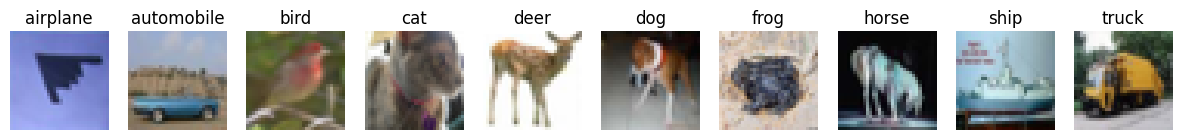

In [45]:
# Q1.
#1) CIFAR-10 dataset

# IndexesOfEachClasses: 각 class 종류마다 해당하는 index 하나씩 넣은 리스트(순서대로)
IndexesOfEachClasses_c = []
for i in range(10):
  for j in range(len(train_c)):
    state = 0
    if i == train_c[j][1]:
      IndexesOfEachClasses_c.append(j)
      break
    else:
      continue

# class 이름
classes_c = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 그림 크기 너무 작아서 title이 겹침
plt.figure(figsize=(15, 2))

# 시각화
for i in range(10):
  plt.subplot(1, 10, i + 1)
  img_tensor = train_c[IndexesOfEachClasses_c[i]][0]
  img_numpy = img_tensor.permute(1, 2, 0).numpy()
  img_numpy = img_numpy * 0.5 + 0.5
  plt.imshow(img_numpy)
  plt.axis('off')
  plt.title(classes_c[i])

plt.show()

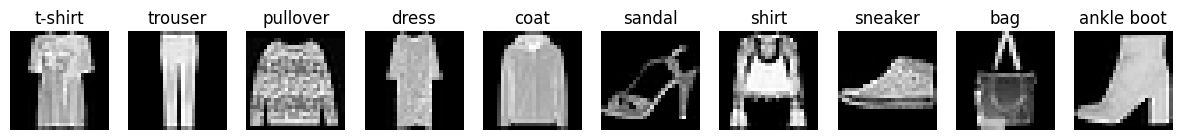

In [46]:
#2) FashionMNIST

# IndexesOfEachClasses_f: 각 class 종류마다 해당하는 index 하나씩 넣은 리스트(순서대로)
IndexesOfEachClasses_f = []
for i in range(10):
  for j in range(len(train_f)):
    state = 0
    if i == train_f[j][1]:
      IndexesOfEachClasses_f.append(j)
      break
    else:
      continue

# class 이름
classes_f = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# 그림 크기 너무 작아서 title이 겹침
plt.figure(figsize=(15, 2))

# 시각화
for i in range(10):
  plt.subplot(1, 10, i + 1)
  img_tensor = train_f[IndexesOfEachClasses_f[i]][0]
  img_numpy = img_tensor.squeeze(0).numpy()
  img_numpy = img_numpy * 0.5 + 0.5
  plt.imshow(img_numpy, cmap='gray')
  plt.axis('off')
  plt.title(classes_f[i])

plt.show()

In [ ]:
# Q2.
## FashionMNIST 가 더 분류하기 쉽다.
## -> CIFAR-10의 배경은 다양한 반면 FashionMNIST의 배경은 전부 검은색
## -> 원래 차원도 FashionMNIST가 더 적은데 배경이 단일한 차이 때문에 더 단순하게 비교 가능

# 문제 2: Logistic Regression vs MLP + Softmax 비교 실험

이 문제에서는 Logistic regression 모델과 MLP 모델을 구성하고, 두 데이터셋을 학습 및 평가합니다.  


- 사용할 데이터셋: `CIFAR-10`, `FashionMNIST` 둘 다 활용합니다.
- **Logistic Regression:** : 1개의 선형 layer + softmax activation 사용
- **MLP:** : 3개의 hidden layer를 사용 (각 hidden layer의 dimension은 100, activation function은 sigmid 함수를 사용합니다.)


<br>
<br>

---

<br>

**모델 구조 및 하이퍼파라미터 조건**

| 모델                | 구성 요소                                            | Epochs | Batch size | Learning rate | Optimizer |
|---------------------|------------------------------------------------------|--------|------------|---------------|-----------|
| Logistic Regression | 1개의 선형 레이어                                    | 10     | 128        | 0.01          | SGD       |
| MLP                 | 3개의 hidden layer (dimension size 100, 활성함수: sigmoid)        | 10     | 128        | 0.01          | SGD       |

> ⚠️ 주의: 설정을 따르지 않을 경우 문제 0점 처리.

## Logistic Regression with CIFAR-10

In [47]:
# Logistic Regression Model for CIFAR-10
class Logistic_Regression_c(nn.Module):
  def __init__(self):
    super(Logistic_Regression_c, self).__init__()
    self.linear = nn.Linear(32*32*3, 10) # 선형 layer(XW + b) 세팅

  def forward(self, x):
    x = x.view(-1, 32*32*3)
    outputs = self.linear(x)
    return outputs

# device: 환경 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Logistic_Regression_Model_c = Logistic_Regression_c().to(device)

# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Logistic_Regression_Model_c.parameters(), lr=0.01)

In [48]:
# 학습

epochs_num = 10

for epoch in range(epochs_num):
  Logistic_Regression_Model_c.train()

  for i, data in enumerate(train_loader_c):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = Logistic_Regression_Model_c(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

In [49]:
# 평가
Logistic_Regression_Model_c.eval()
valid_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
  for data in valid_loader_c:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = Logistic_Regression_Model_c(inputs)

    loss = criterion(outputs, labels)
    valid_loss = valid_loss + loss.item()

    _,predicted = torch.max(outputs.data, 1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum().item()

avg_valid_loss = valid_loss / len(valid_loader_c)
accuracy = 100 * correct / total

print(accuracy)

39.72


## Rogistic Regression with FashionMNIST

In [50]:
# Logistic Regression Model for FashionMNIST
class Logistic_Regression_f(nn.Module):
  def __init__(self):
    super(Logistic_Regression_f, self).__init__()
    self.linear = nn.Linear(28*28, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    outputs = self.linear(x)
    return outputs

# device: 환경 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Logistic_Regression_Model_f = Logistic_Regression_f().to(device)

# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Logistic_Regression_Model_f.parameters(), lr=0.01)

In [51]:
# 학습

epochs_num = 10

for epoch in range(epochs_num):
  Logistic_Regression_Model_f.train()

  for i, data in enumerate(train_loader_f):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = Logistic_Regression_Model_f(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

In [52]:
# 평가
Logistic_Regression_Model_f.eval()
correct = 0
total = 0

with torch.no_grad():
  for data in valid_loader_f:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = Logistic_Regression_Model_f(inputs)

    loss = criterion(outputs, labels)

    _,predicted = torch.max(outputs.data, 1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(accuracy)

83.71666666666667


## MLP with CIFAR-10

In [53]:
# MLP Model for CIFAR-10
class MLP_c(nn.Module):
  def __init__(self):
    super(MLP_c, self).__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, 100)
    self.sigmoid1 = nn.Sigmoid()
    self.fc2 = nn.Linear(100, 100)
    self.sigmoid2 = nn.Sigmoid()
    self.fc3 = nn.Linear(100, 100)
    self.sigmoid3 = nn.Sigmoid()
    self.fc4 = nn.Linear(100, 10)

  def forward(self, x):
    x = x.view(-1, 32 * 32 * 3)
    x = self.sigmoid1(self.fc1(x))
    x = self.sigmoid2(self.fc2(x))
    x = self.sigmoid3(self.fc3(x))
    x = self.fc4(x)
    return x

# device: 환경 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLP_Model_c = MLP_c().to(device)

# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MLP_Model_c.parameters(), lr=0.01)

In [54]:
# 학습

epochs_num = 10

for epoch in range(epochs_num):
  MLP_Model_c.train()

  for i, data in enumerate(train_loader_c):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = MLP_Model_c(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

In [55]:
# 평가
MLP_Model_c.eval()
correct = 0
total = 0

with torch.no_grad():
  for data in valid_loader_c:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = MLP_Model_c(inputs)

    _,predicted = torch.max(outputs.data, 1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(accuracy)

9.86


## MLP with FashionMNIST

In [56]:
# MLP Model for FashionMNIST
class MLP_f(nn.Module):
  def __init__(self):
    super(MLP_f, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 100)
    self.sigmoid1 = nn.Sigmoid()
    self.fc2 = nn.Linear(100, 100)
    self.sigmoid2 = nn.Sigmoid()
    self.fc3 = nn.Linear(100, 100)
    self.sigmoid3 = nn.Sigmoid()
    self.fc4 = nn.Linear(100, 10)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.sigmoid1(self.fc1(x))
    x = self.sigmoid2(self.fc2(x))
    x = self.sigmoid3(self.fc3(x))
    x = self.fc4(x)
    return x

# device: 환경 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLP_Model_f = MLP_f().to(device)

# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MLP_Model_f.parameters(), lr=0.01)

In [57]:
# 학습

epochs_num = 10

for epoch in range(epochs_num):
  MLP_Model_f.train()

  for i, data in enumerate(train_loader_f):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = MLP_Model_f(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

In [58]:
# 평가
MLP_Model_f.eval()
correct = 0
total = 0

with torch.no_grad():
  for data in valid_loader_f:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = MLP_Model_f(inputs)

    _,predicted = torch.max(outputs.data, 1)
    total = total + labels.size(0)
    correct = correct + (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(accuracy)

16.466666666666665


# 문제 3: MLP에 정규화 기법 적용

이번 문제에서는 문제 1에서 만든 MLP 모델에 정규화 기법들을 적용해 봅시다.


<br>

**모델 구조 및 하이퍼파라미터 조건**

| 모델                | 구성 요소                                            | Epochs | Batch size | Learning rate | Optimizer |
|---------------------|------------------------------------------------------|--------|------------|---------------|-----------|
| MLP | 3개의 hidden layer (dimension size 100, 활성함수: sigmoid)                                    | 30     | 128        | 0.01          | SGD       |
| MLP + Regularization                 | 각 layer에 batch norm, dropout 적용, L2 Regularization 적용        | 30     | 128        | 0.01          | SGD       |


> ⚠️ 주의: 설정을 따르지 않을 경우 문제 0점 처리.
<br>

---

<br>

## 보고서 작성 내용
두 데이터셋에 대해서  MLP 모델과 정규화를 추가한 모델의 의 train valdation에 대한 learning curve를 그리고, 분석하시오.

## MLP with CIFAR-10

In [59]:
# learning curve 그리기 위한 리스트들
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [60]:
# epochs_num만 30으로 바꿔서 학습

epochs_num = 30

for epoch in range(epochs_num):
  MLP_Model_c.train()

  train_loss = 0
  train_correct = 0
  train_total = 0

  for i, data in enumerate(train_loader_c):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = MLP_Model_c(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  avg_train_loss = train_loss / len(train_loader_c)
  train_accuracy = 100 * train_correct / train_total
  train_losses.append(avg_train_loss)
  train_accuracies.append(train_accuracy)

  MLP_Model_c.eval()
  valid_loss = 0
  valid_correct = 0
  valid_total = 0

  with torch.no_grad():
    for data in valid_loader_c:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = MLP_Model_c(inputs)
      loss = criterion(outputs, labels)
      valid_loss += loss.item()

      _,predicted = torch.max(outputs.data, 1)
      valid_total +=labels.size(0)
      valid_correct += (predicted == labels).sum().item()

  avg_valid_loss = valid_loss / len(valid_loader_c)
  valid_accuracy = 100 * valid_correct / valid_total
  valid_losses.append(avg_valid_loss)
  valid_accuracies.append(valid_accuracy)

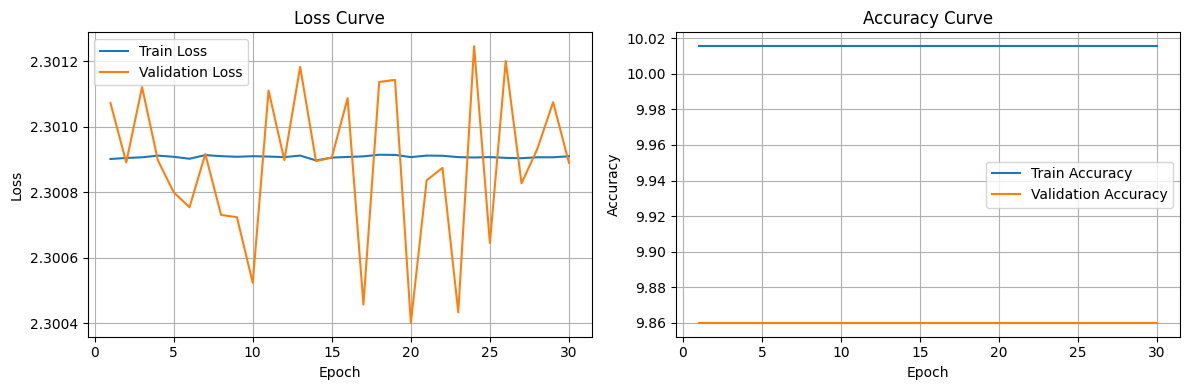

In [61]:
# Learning Curve - Loss / Accuracy Curve
epochs = range(1, epochs_num + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## MLP with FashionMNIST

In [62]:
# learning curve 그리기 위한 리스트들
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [63]:
# epochs_num만 30으로 바꿔서 학습

epochs_num = 30

for epoch in range(epochs_num):
  MLP_Model_f.train()

  train_loss = 0
  train_correct = 0
  train_total = 0

  for i, data in enumerate(train_loader_f):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = MLP_Model_f(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  avg_train_loss = train_loss / len(train_loader_f)
  train_accuracy = 100 * train_correct / train_total
  train_losses.append(avg_train_loss)
  train_accuracies.append(train_accuracy)

  MLP_Model_f.eval()
  valid_loss = 0
  valid_correct = 0
  valid_total = 0

  with torch.no_grad():
    for data in valid_loader_f:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = MLP_Model_f(inputs)
      loss = criterion(outputs, labels)
      valid_loss += loss.item()

      _,predicted = torch.max(outputs.data, 1)
      valid_total +=labels.size(0)
      valid_correct += (predicted == labels).sum().item()

  avg_valid_loss = valid_loss / len(valid_loader_f)
  valid_accuracy = 100 * valid_correct / valid_total
  valid_losses.append(avg_valid_loss)
  valid_accuracies.append(valid_accuracy)

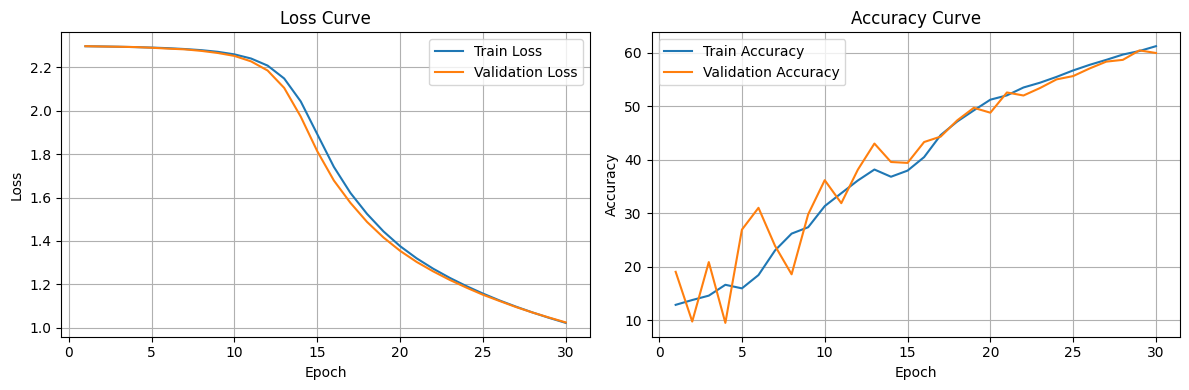

In [64]:
# Learning Curve - Loss / Accuracy Curve
epochs = range(1, epochs_num + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## MLP + Regularization with CIFAR-10

In [65]:
# learning curve 그리기 위한 리스트들
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [66]:
# MLP + Regularization Model for CIFAR-10
class MLP_reg_c(nn.Module):
  def __init__(self):
    super(MLP_reg_c, self).__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, 100)
    self.bn1 = nn.BatchNorm1d(100)
    self.sigmoid1 = nn.Sigmoid()
    self.dropout1 = nn.Dropout(p=0.5)

    self.fc2 = nn.Linear(100, 100)
    self.bn2 = nn.BatchNorm1d(100)
    self.sigmoid2 = nn.Sigmoid()
    self.dropout2 = nn.Dropout(p=0.5)

    self.fc3 = nn.Linear(100, 100)
    self.bn3 = nn.BatchNorm1d(100)
    self.sigmoid3 = nn.Sigmoid()
    self.dropout3 = nn.Dropout(p=0.5)

    self.fc4 = nn.Linear(100, 10)

  def forward(self, x):
    x = x.view(-1, 32 * 32 * 3)
    x = self.dropout1(self.sigmoid1(self.bn1((self.fc1(x)))))
    x = self.dropout2(self.sigmoid2(self.bn2((self.fc2(x)))))
    x = self.dropout3(self.sigmoid3(self.bn3((self.fc3(x)))))
    x = self.fc4(x)
    return x

# device: 환경 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLP_reg_Model_c = MLP_reg_c().to(device)

# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MLP_reg_Model_c.parameters(), lr=0.01, weight_decay=0.01)

In [67]:
# 학습

epochs_num = 30

for epoch in range(epochs_num):
  MLP_reg_Model_c.train()

  train_loss = 0
  train_correct = 0
  train_total = 0

  for i, data in enumerate(train_loader_c):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = MLP_reg_Model_c(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  avg_train_loss = train_loss / len(train_loader_c)
  train_accuracy = 100 * train_correct / train_total
  train_losses.append(avg_train_loss)
  train_accuracies.append(train_accuracy)

  MLP_reg_Model_c.eval()
  valid_loss = 0
  valid_correct = 0
  valid_total = 0

  with torch.no_grad():
    for data in valid_loader_c:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = MLP_reg_Model_c(inputs)
      loss = criterion(outputs, labels)
      valid_loss += loss.item()

      _,predicted = torch.max(outputs.data, 1)
      valid_total +=labels.size(0)
      valid_correct += (predicted == labels).sum().item()

  avg_valid_loss = valid_loss / len(valid_loader_f)
  valid_accuracy = 100 * valid_correct / valid_total
  valid_losses.append(avg_valid_loss)
  valid_accuracies.append(valid_accuracy)

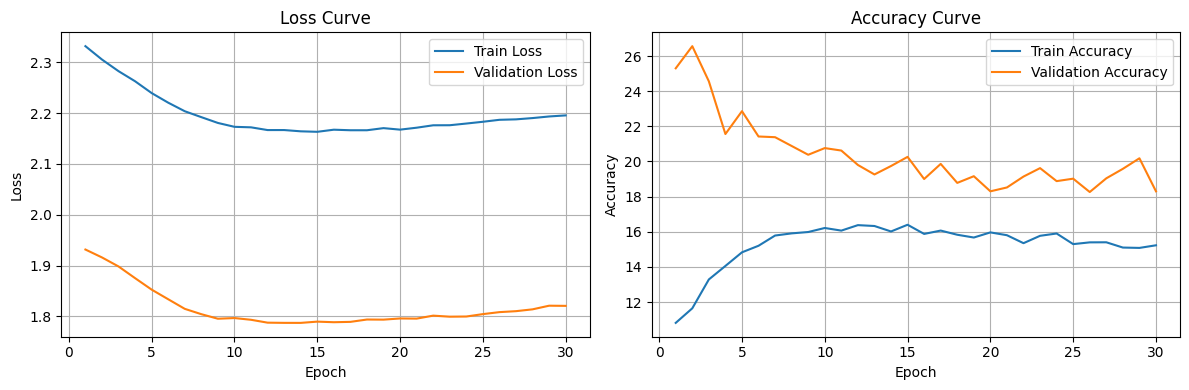

In [68]:
# Learning Curve - Loss / Accuracy Curve
epochs = range(1, epochs_num + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## MLP + Regularization with FashionMNIST

In [69]:
# learning curve 그리기 위한 리스트들
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [70]:
# MLP + Regularization Model for FashionMNIST
class MLP_reg_f(nn.Module):
  def __init__(self):
    super(MLP_reg_f, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 100)
    self.bn1 = nn.BatchNorm1d(100)
    self.sigmoid1 = nn.Sigmoid()
    self.dropout1 = nn.Dropout(p=0.5)

    self.fc2 = nn.Linear(100, 100)
    self.bn2 = nn.BatchNorm1d(100)
    self.sigmoid2 = nn.Sigmoid()
    self.dropout2 = nn.Dropout(p=0.5)

    self.fc3 = nn.Linear(100, 100)
    self.bn3 = nn.BatchNorm1d(100)
    self.sigmoid3 = nn.Sigmoid()
    self.dropout3 = nn.Dropout(p=0.5)

    self.fc4 = nn.Linear(100, 10)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.dropout1(self.sigmoid1(self.bn1(self.fc1(x))))
    x = self.dropout2(self.sigmoid2(self.bn2(self.fc2(x))))
    x = self.dropout3(self.sigmoid3(self.bn3(self.fc3(x))))
    x = self.fc4(x)
    return x

# device: 환경 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLP_reg_Model_f = MLP_reg_f().to(device)

# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MLP_reg_Model_f.parameters(), lr=0.01, weight_decay=0.01)

In [71]:
# 학습

epochs_num = 30

for epoch in range(epochs_num):
  MLP_reg_Model_f.train()

  train_loss = 0
  train_correct = 0
  train_total = 0

  for i, data in enumerate(train_loader_f):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = MLP_reg_Model_f(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  avg_train_loss = train_loss / len(train_loader_f)
  train_accuracy = 100 * train_correct / train_total
  train_losses.append(avg_train_loss)
  train_accuracies.append(train_accuracy)

  MLP_reg_Model_f.eval()
  valid_loss = 0
  valid_correct = 0
  valid_total = 0

  with torch.no_grad():
    for data in valid_loader_f:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = MLP_reg_Model_f(inputs)
      loss = criterion(outputs, labels)
      valid_loss += loss.item()

      _,predicted = torch.max(outputs.data, 1)
      valid_total +=labels.size(0)
      valid_correct += (predicted == labels).sum().item()

  avg_valid_loss = valid_loss / len(valid_loader_f)
  valid_accuracy = 100 * valid_correct / valid_total
  valid_losses.append(avg_valid_loss)
  valid_accuracies.append(valid_accuracy)

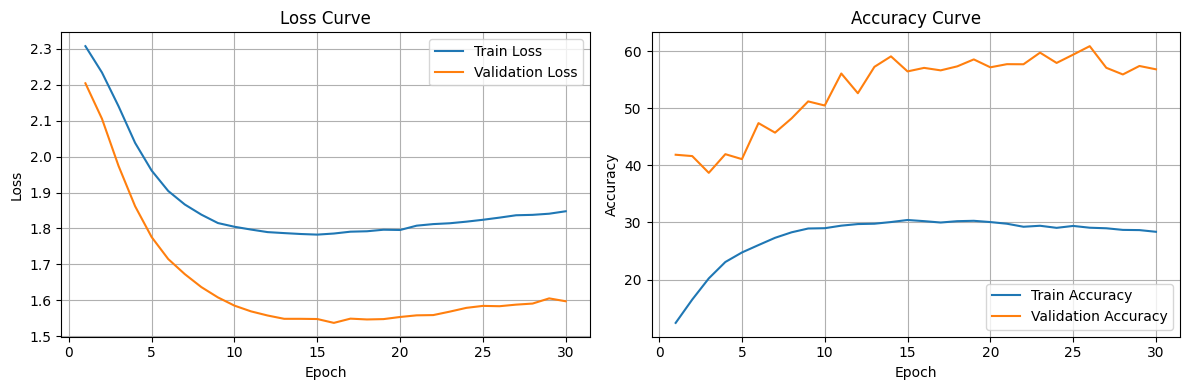

In [72]:
# Learning Curve - Loss / Accuracy Curve
epochs = range(1, epochs_num + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 문제 4: 자신만의 MLP 모델 구현

자유롭게 MLP 모델을 구현하고, CIFAR-10에 대해서 Accurcy 60% 이상의 성능을 달성하시오.


<br>

---
<br>

고려 가능한 조건들 (수업시간에 다룬 내용?)

- 모델 구조 : Layer 수, dimension 사이즈, Activation function
- 정규화 기법 : Batch norm, dropout, L1,L2 Regularization
- 학습 관련 하이퍼파라미터 : Learning rate, Batch 크기, Epochs, Loss function, Optimizer 등등
- Skip-connection 등등
- 데이터 증강 기법 : Data Augmentation (data loader 변경 가능합니다.)

<br>



<br>

---
<br>

## 보고서 작성 내용

- 최종 선택한 하이퍼파라미터 세팅과 함께 이제 다중분류에서 class마다  accuracy, f1 score, precision, recall을 기록하시오.
- 성능 향상을 위해 시도했던 방법들에 대해서 서술하고, 가장 효과적이였던 기법에 대해서 서술하시오.

In [73]:
# myMLP Model for CIFAR-10

# 1) Activation function: Sigmoid -> ReLU
# 2) Optimizer: SGD -> Adam
# 3) Perceptron 개수: 3072 -> 512 -> 256 -> 128 -> 10

class myMLP(nn.Module):
  def __init__(self):
    super(myMLP, self).__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, 512)
    self.bn1 = nn.BatchNorm1d(512)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(p=0.5)

    self.fc2 = nn.Linear(512, 256)
    self.bn2 = nn.BatchNorm1d(256)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(p=0.5)

    self.fc3 = nn.Linear(256, 128)
    self.bn3 = nn.BatchNorm1d(128)
    self.relu3 = nn.ReLU()
    self.dropout3 = nn.Dropout(p=0.5)

    self.fc4 = nn.Linear(128, 10)

  def forward(self, x):
    x = x.view(-1, 32 * 32 * 3)
    x = self.dropout1(self.relu1(self.bn1((self.fc1(x)))))
    x = self.dropout2(self.relu2(self.bn2((self.fc2(x)))))
    x = self.dropout3(self.relu3(self.bn3((self.fc3(x)))))
    x = self.fc4(x)
    return x

# device: 환경 세팅
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
myMLPModel = myMLP().to(device)

# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(myMLPModel.parameters(), lr=0.01, weight_decay=0.01)

In [74]:
# training dataset 학습

epochs_num = 30

for epoch in range(epochs_num):
  myMLPModel.train()

  for i, data in enumerate(train_loader_c):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = myMLPModel(inputs)

    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

In [75]:
from sklearn.metrics import classification_report

In [76]:
# 실제와 예측 label 저장
true_labels = []
pred_labels = []

# test
myMLPModel.eval()

with torch.no_grad():
    for images, labels in test_loader_c:
        images, labels = images.to(device), labels.to(device)
        outputs = myMLPModel(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Classification Report
report = classification_report(true_labels, pred_labels, target_names=classes_c, digits=2)
print(report)

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.08      0.13      0.10      1000
        bird       0.00      0.00      0.00      1000
         cat       0.14      0.47      0.21      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.23      0.02      0.04      1000
       horse       0.00      0.00      0.00      1000
        ship       0.19      0.84      0.31      1000
       truck       0.13      0.08      0.10      1000

    accuracy                           0.15     10000
   macro avg       0.08      0.15      0.08     10000
weighted avg       0.08      0.15      0.08     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
